<a href="https://colab.research.google.com/github/chamathjh/VaR_and_stressed_VaR/blob/main/VaR_and_stressed_VaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np

# Example portfolio of real assets
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

# Download 1 year of daily data
data = yf.download(tickers, start='2023-01-01', end='2024-01-01')

# downloading adjusted close prices
adj_close = data['Close']
adj_close.head()

/tmp/ipython-input-61293069.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start='2023-01-01', end='2024-01-01')
[*********************100%***********************]  5 of 5 completed


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2023-01-03,123.211205,85.820000,88.451691,233.985672,108.099998
2023-01-04,124.482040,85.139999,87.419479,223.750351,113.639999
2023-01-05,123.161942,83.120003,85.553574,217.118912,110.339996
2023-01-06,127.693581,86.080002,86.685020,219.677734,113.059998
2023-01-09,128.215668,87.360001,87.359924,221.816559,119.769997


In [17]:
returns = adj_close.pct_change().dropna()
returns.head()


Ticker,AAPL,AMZN,GOOGL,MSFT,TSLA
Date,,,,,
2023-01-04,0.010314,-0.007924,-0.011670,-0.043743,0.051249
2023-01-05,-0.010605,-0.023726,-0.021344,-0.029638,-0.029039
2023-01-06,0.036794,0.035611,0.013225,0.011785,0.024651
2023-01-09,0.004089,0.014870,0.007786,0.009736,0.059349
2023-01-10,0.004457,0.028732,0.004545,0.007617,-0.007681


In [18]:
weights = np.array([0.2, 0.3, 0.2, 0.1, 0.2])
portfolio_returns = returns.dot(weights)


In [22]:
confidence_level = 0.99  # 99% confidence
holding_period = 1       # 1-day VaR


In [23]:
from scipy.stats import norm

mu = portfolio_returns.mean()
sigma = portfolio_returns.std()

VaR_parametric = -(mu * holding_period + sigma * np.sqrt(holding_period) * norm.ppf(confidence_level))
print(f"Parametric VaR (99%): {VaR_parametric:.4f}")


Parametric VaR (99%): -0.0393


In [24]:
VaR_historical = -np.percentile(portfolio_returns, (1 - confidence_level) * 100)
print(f"Historical VaR (99%): {VaR_historical:.4f}")


Historical VaR (99%): 0.0301


In [25]:
simulations = 100000
mean_returns = returns.mean().values
cov_matrix = returns.cov().values

# Simulate correlated returns
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, simulations).dot(weights)
VaR_monte_carlo = -np.percentile(simulated_returns, (1 - confidence_level) * 100)
print(f"Monte Carlo VaR (99%): {VaR_monte_carlo:.4f}")


Monte Carlo VaR (99%): 0.0343


In [31]:
# Define a stress period
stress_start = '2020-02-01'
stress_end = '2021-04-30'

# Pull historical prices for the stress period
stress_data = yf.download(tickers, start=stress_start, end=stress_end, auto_adjust=True)['Close']
stress_returns = stress_data.pct_change().dropna()
stress_portfolio_returns = stress_returns.dot(weights)

# Compute Historical sVaR
sVaR_historical = -np.percentile(stress_portfolio_returns, (1 - confidence_level) * 100)
print(f"Stressed Historical VaR (99%): {sVaR_historical:.4f}")


[*********************100%***********************]  5 of 5 completed

Stressed Historical VaR (99%): 0.0772


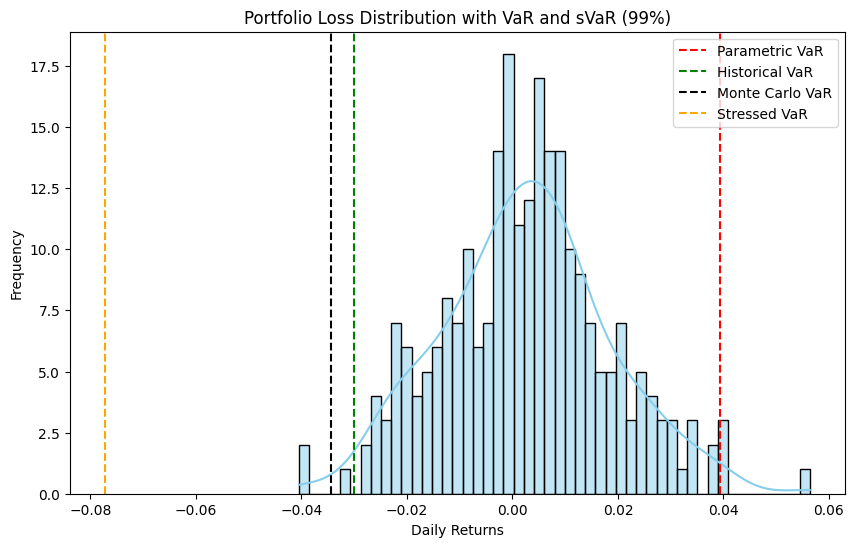

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(portfolio_returns, bins=50, kde=True, color='skyblue')
plt.axvline(-VaR_parametric, color='red', linestyle='--', label='Parametric VaR')
plt.axvline(-VaR_historical, color='green', linestyle='--', label='Historical VaR')
plt.axvline(-VaR_monte_carlo, color='black', linestyle='--', label='Monte Carlo VaR')
plt.axvline(-sVaR_historical, color='orange', linestyle='--', label='Stressed VaR')
plt.title('Portfolio Loss Distribution with VaR and sVaR (99%)')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()
